![ieseg logo](./img/ieseg.png)

#### MBD 2019-2020
# Statistical & Machine Learning Approaches for Marketing

## Section 1: Introduction & Linear Regression

**1. Import all required libraries and datasets**

In [4]:
# Set environment params
Sys.setenv(LANG='en')  # English
# Import libraries
library(data.table)  # Data manipulate
library(mlr)         # ML toolkit
library(caret)       # ML toolkit
library(ggplot2)     # Visualization
library(pheatmap)
library(psych)

# Import data
library(ISLR)      # Data from the course book
library(MASS)      # Boston housing dataset
library(datasets)  # US crime dataset

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Warning message:
"package 'mlr' was built under R version 3.6.2"

ERROR: Error: package or namespace load failed for 'mlr' in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace 'data.table' 1.12.2 is already loaded, but >= 1.12.4 is required


In [101]:
# Install missing packages
#install.packages("ISLR")
#install.packages("pheatmap")
#install.packages("psych")

package 'pheatmap' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\lenovo\AppData\Local\Temp\RtmpaMs4tL\downloaded_packages


**2. Simulate Bias-Variance trade-off**  

Source: https://daviddalpiaz.github.io/r4sl/biasvariance-tradeoff.html

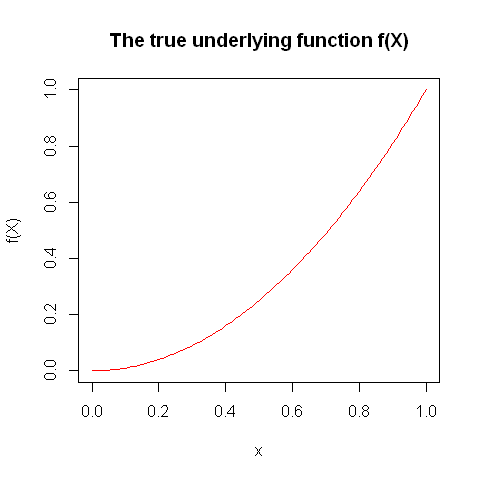

In [5]:
# The true underlying function
f <- function(x) {
  x ^ 2
}

# Plot the underlying function
options(repr.plot.width=4, repr.plot.height=4)  # Set plot size
op <- par(cex = 0.8)  # Set font size

plot(f, type='l', col='red',
     main="The true underlying function f(X)",
     ylab="f(X)", xlab="x")

In [6]:
# Function to generate simulation data from true function f
get_sim_data <- function(f, sample_size=100) {
  x <- runif(n=sample_size, min=0, max=1)  # Generate a list of x values
  eps <- rnorm(n=sample_size, mean=0, sd=0.75)  # Generate random errors
  y <- f(x) + eps
  data.frame(x, y)
}

In [7]:
# Generate simulation data
set.seed(1)
n_sims <- 250  # Number of simulations
n_models <- 4  # Number of models
x <- data.frame(x=0.90)  # Fixed point at which we make predictions [test]
predictions <- matrix(0, nrow=n_sims, ncol=n_models)  # Blank matrix

In [3]:
# Run the simulation
for (sim in 1:n_sims) {
  # Simulate new, random, training data
  sim_data <- get_sim_data(f)

  # Fit different models
  fit_0 <- lm(y ~ 1,                 data=sim_data)  # Simple linear regression
  fit_1 <- lm(y ~ poly(x, degree=1), data=sim_data)  # Polynomial regression (degree = 1)
  fit_2 <- lm(y ~ poly(x, degree=2), data=sim_data)  # Polynomial regression (degree = 2)
  fit_9 <- lm(y ~ poly(x, degree=9), data=sim_data)  # Polynomial regression (degree = 9)

  # Get predictions
  predictions[sim, 1] <- predict(fit_0, x)
  predictions[sim, 2] <- predict(fit_1, x)
  predictions[sim, 3] <- predict(fit_2, x)
  predictions[sim, 4] <- predict(fit_9, x)
}

ERROR: Error in get_sim_data(f): 找不到对象'f'


In [9]:
# Prediction results of 4 models
head(predictions)

0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0


In [10]:
# Function to calculate mse, bias, variance
get_mse <- function(truth, estimate) {
  mean((estimate - truth) ^ 2)
}

get_bias <- function(estimate, truth) {
  mean(estimate) - truth
}

get_var <- function(estimate) {
  mean((estimate - mean(estimate)) ^ 2)
}

In [11]:
# Run the simulate
bias <- apply(predictions, 2, get_bias, truth=f(x=0.90))
variance <- apply(predictions, 2, get_var)
mse <- apply(predictions, 2, get_mse, truth=f(x=0.90))

In [12]:
# Prepare the data for plotting
bvto <- data.frame(degree=c(0, 1, 2, 9), mse=mse, bias_squared=bias^2, variance=variance)
bvto

degree,mse,bias_squared,variance
0,0.6561,0.6561,0
1,0.6561,0.6561,0
2,0.6561,0.6561,0
9,0.6561,0.6561,0


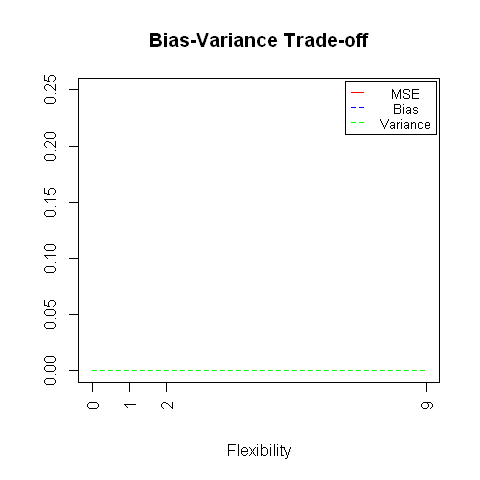

In [13]:
# Plot the Bias-Variance Trade-off
options(repr.plot.width=4, repr.plot.height=4)  # Set plot size
op <- par(cex = 0.8)  # Set font size

plot(bvto$degree, bvto$mse, type='l', col='red', ylim=c(0, 0.25),
     main="Bias-Variance Trade-off",
     ylab="", xlab="Flexibility",
     xaxt="n")  # MSE
lines(bvto$degree, bvto$bias_squared, col='blue', type="l", lty=2)  # Bias
lines(bvto$degree, bvto$variance, col='green', type="l", lty=2)  # Variance

op <- par(cex = 0.8)  # Set font size
axis(side=1, at=c(0, 1, 2, 9), las=2)  # Add x tickers
legend("topright", legend=c("MSE", "Bias", "Variance"),
       col=c("red", "blue", "green"), lty=c(1, 2, 2), cex=0.8,
       x.intersp=7, y.intersp=2, adj=0.5, inset=0.01)

**3. Simple Linear Regression**

In [14]:
# Import Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


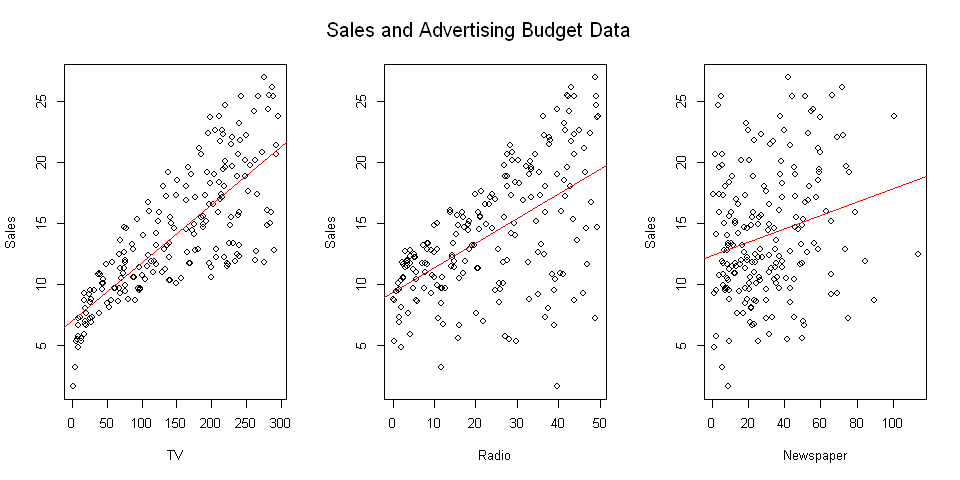

In [15]:
# Plot the data
options(repr.plot.width=8, repr.plot.height=4)  # Set plot size
par(mfrow=c(1, 3))  # Set the plot regions

plot(adv$TV, adv$sales, ylab="Sales", xlab="TV")
abline(lm(sales ~ TV, data=adv), col='red')

plot(adv$radio, adv$sales, ylab="Sales", xlab="Radio")
abline(lm(sales ~ radio, data=adv), col='red')

plot(adv$newspaper, adv$sales, ylab="Sales", xlab="Newspaper")
abline(lm(sales ~ newspaper, data=adv), col='red')

mtext("Sales and Advertising Budget Data", side=3, line=-2.5, outer=TRUE)

**Estimation of the parameters by least squares**

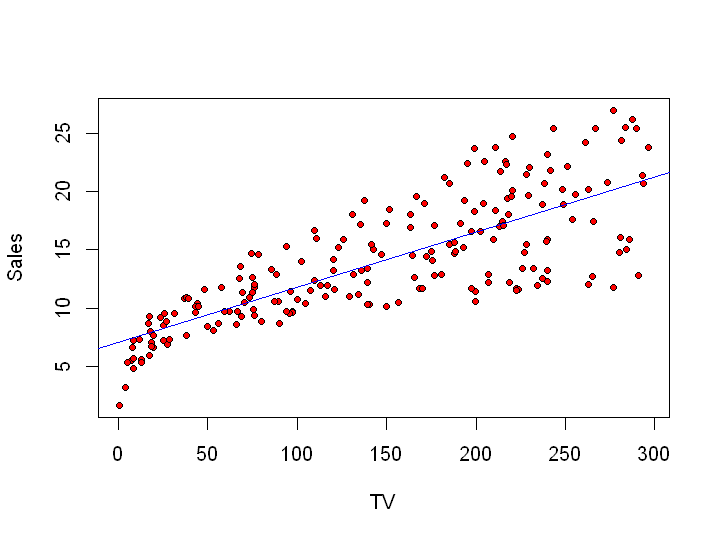

In [122]:
# Plot Sales ~ TV
options(repr.plot.width=6, repr.plot.height=4.5)  # Set plot size

plot(adv$TV, adv$sales, pch=21, cex=0.8, bg='red',
     xlab='TV', ylab='Sales')
abline(lm(sales ~ TV, data=adv), col='blue')

**Exercise 1:** Calculate B0, B1 for Sales ~ f(TV)

In [96]:
md <- lm(sales ~ TV, data=adv)
coefficients(md ) 

(Intercept)          TV 
 7.03259355  0.04753664

In [124]:
# Check B0, B1 by lm function
md1 <- lm(sales ~ TV, data=adv)
summary(md1)


Call:
lm(formula = sales ~ TV, data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3860 -1.9545 -0.1913  2.0671  7.2124 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.032594   0.457843   15.36   <2e-16 ***
TV          0.047537   0.002691   17.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.259 on 198 degrees of freedom
Multiple R-squared:  0.6119,	Adjusted R-squared:  0.6099 
F-statistic: 312.1 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 2:** Calculate B0, B1 for Sales ~ f(Radio)

In [18]:
md2<- lm(sales ~ radio, data=adv)
coefficients(md2)

(Intercept)       radio 
  9.3116381   0.2024958

In [126]:
# Check B0, B1 by lm function
summary(lm(sales ~ radio, data=adv))


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 3:** Calculate the 95% confidence interval of B0, B1 for model Sales ~ f(TV)?

In [24]:
md1 <- lm(sales ~ TV, data=adv)
#confint(md1)
confint(md1,level=.9)

,5 %,95 %
(Intercept),6.27596881,7.7892183
TV,0.04309018,0.0519831


In [128]:
# Double check with the lm function
md <- lm(sales ~ TV, data=adv)
summary(md)


Call:
lm(formula = sales ~ TV, data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3860 -1.9545 -0.1913  2.0671  7.2124 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.032594   0.457843   15.36   <2e-16 ***
TV          0.047537   0.002691   17.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.259 on 198 degrees of freedom
Multiple R-squared:  0.6119,	Adjusted R-squared:  0.6099 
F-statistic: 312.1 on 1 and 198 DF,  p-value: < 2.2e-16


**Exercise 4:** Calculate the t-statistic and p-value for predictors radio and newspaper.

Calculate t-statistic for Sales ~ f(Radio)

In [16]:
# Show the model of Sales ~ f(Radio)
md2 <- lm(sales ~ radio, data=adv)
summary(md2)


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


In [26]:
# p value
coef(summary(md2))[,4]
#t value
coef(summary(md2))[,3]

(Intercept)        radio 
3.561071e-39 4.354966e-19

(Intercept)       radio 
  16.542245    9.920765

Calculate t-statistic for Sales ~ f(Newspaper)

In [28]:
# Show the model of Sales ~ f(Newspaper)
md3 <- lm(sales ~ newspaper, data=adv)
summary(md3)


Call:
lm(formula = sales ~ newspaper, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2272  -3.3873  -0.8392   3.5059  12.7751 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.35141    0.62142   19.88  < 2e-16 ***
newspaper    0.05469    0.01658    3.30  0.00115 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.092 on 198 degrees of freedom
Multiple R-squared:  0.05212,	Adjusted R-squared:  0.04733 
F-statistic: 10.89 on 1 and 198 DF,  p-value: 0.001148


In [29]:
# p value
coef(summary(md3))[,4]
#t value
coef(summary(md3))[,3]

(Intercept)    newspaper 
4.713507e-49 1.148196e-03

(Intercept)   newspaper 
  19.876096    3.299591

**Exercise 5:** Calculate the RSE and R-squared for predictors radio and newspaper.

Calculate the RSE and R-squared for Sales ~ f(Radio)

In [30]:
# Show the model of Sales ~ f(Radio)
md2 <- lm(sales ~ radio, data=adv)
summary(md2)


Call:
lm(formula = sales ~ radio, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.7305  -2.1324   0.7707   2.7775   8.1810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.31164    0.56290  16.542   <2e-16 ***
radio        0.20250    0.02041   9.921   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.275 on 198 degrees of freedom
Multiple R-squared:  0.332,	Adjusted R-squared:  0.3287 
F-statistic: 98.42 on 1 and 198 DF,  p-value: < 2.2e-16


In [49]:
# RSE
coef(summary(md2))[ ,2]
# R-squared
summary(md2)$r.squared
#Adjusted R-squared
summary(md2)$adj.r.squared

(Intercept)       radio 
 0.56290050  0.02041131

[1] 0.3320325

[1] 0.3286589

Calculate the RSE and R-squared for Sales ~ f(Newspaper)

In [46]:
# Show the model of Sales ~ f(Newspaper)
md3 <- lm(sales ~ newspaper, data=adv)
summary(md3)


Call:
lm(formula = sales ~ newspaper, data = adv)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2272  -3.3873  -0.8392   3.5059  12.7751 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.35141    0.62142   19.88  < 2e-16 ***
newspaper    0.05469    0.01658    3.30  0.00115 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.092 on 198 degrees of freedom
Multiple R-squared:  0.05212,	Adjusted R-squared:  0.04733 
F-statistic: 10.89 on 1 and 198 DF,  p-value: 0.001148


In [50]:
# RSE
coef(summary(md3))[ ,2]
# R-squared
summary(md3)$r.squared
#Adjusted R-squared
summary(md3)$adj.r.squared

(Intercept)   newspaper 
 0.62142019  0.01657572

[1] 0.05212045

[1] 0.04733317

**4. Multiple Linear Regression**

In [53]:
# Import Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)
str(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


'data.frame':	200 obs. of  4 variables:
 $ TV       : num  230.1 44.5 17.2 151.5 180.8 ...
 $ radio    : num  37.8 39.3 45.9 41.3 10.8 48.9 32.8 19.6 2.1 2.6 ...
 $ newspaper: num  69.2 45.1 69.3 58.5 58.4 75 23.5 11.6 1 21.2 ...
 $ sales    : num  22.1 10.4 9.3 18.5 12.9 7.2 11.8 13.2 4.8 10.6 ...


**Exercise 6:** Use the matrix formula to estimate the parameters of multilinear regression model.

ERROR: Error in model.frame.default(formula = y ~ x, drop.unused.levels = TRUE): invalid type (list) for variable 'y'


In [110]:
# Compare with the function of R
md <- lm(sales ~ ., data=adv)
summary(md)


Call:
lm(formula = sales ~ ., data = adv)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
radio        0.188530   0.008611  21.893   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


## Lab: 

1. Construct your own Multiple Linear Regression model on Credit data.

2. Linear Regression with Interactions term on Advertising data.

3. Polynomial regression on Auto data.

**1. Construct your own Multiple Linear Regression model on Credit data: Predict customer balance**

In [168]:
# Import data
credit <- read.csv('./data/Credit.csv', row.names=1)
head(credit)

Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
104.593,7075,514,4,71,11,Male,No,No,Asian,580
148.924,9504,681,3,36,11,Female,No,No,Asian,964
55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151


Using the matrix formula to manually estimate the multiple linear regression model with 3 predictors Age, Rating, Limit.

ERROR: Error in scatterplotMatrix(w[, -1], spread = F, lty.smooth = 2, main = "Matrix"): could not find function "scatterplotMatrix"


In [73]:
# Compare with function of R
md_full <- lm(Balance ~ Age + Rating + Limit, data=credit)
summary(md_full)


Call:
lm(formula = Balance ~ Age + Rating + Limit, data = credit)

Residuals:
    Min      1Q  Median      3Q     Max 
-729.67 -135.82   -8.58  127.29  827.65 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -259.51752   55.88219  -4.644 4.66e-06 ***
Age           -2.34575    0.66861  -3.508 0.000503 ***
Rating         2.31046    0.93953   2.459 0.014352 *  
Limit          0.01901    0.06296   0.302 0.762830    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 229.1 on 396 degrees of freedom
Multiple R-squared:  0.7536,	Adjusted R-squared:  0.7517 
F-statistic: 403.7 on 3 and 396 DF,  p-value: < 2.2e-16


**2. Linear Regression with Interactions term on Advertising data: Predict sales**

In [171]:
# Read Advertising data
adv <- read.csv('./data/Advertising.csv', row.names=1)
head(adv)

TV,radio,newspaper,sales
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


In [69]:
# Prediction when TV=40,radio=32,newspaper=78
md4 <- lm(sales ~ ., data=adv)
newdata<-data.frame(TV=40,radio=32,newspaper=78)
pre<-predict(md4,newdata,interval="prediction",level=0.95)
pre

fit,lwr,upr
10.72151,7.334193,14.10883


**3. Polynomial regression on Auto data: Predict miles per gallon of the car (mpg)**

In [176]:
# Import data
auto <- fread('./data/Auto.csv')
auto$horsepower <- as.numeric(auto$horsepower)  # Correct data format
head(auto)
str(auto)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,1,buick skylark 320
18,8,318,150,3436,11.0,70,1,plymouth satellite
16,8,304,150,3433,12.0,70,1,amc rebel sst
17,8,302,140,3449,10.5,70,1,ford torino
15,8,429,198,4341,10.0,70,1,ford galaxie 500


Classes 'data.table' and 'data.frame':	397 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : int  3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ name        : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...
 - attr(*, ".internal.selfref")=<externalptr> 


# Exercise 2 (p.52, Chap.2), 10 (p.56, Chap.2), 3 (p.120, Chap.3), 10 (p.123, Chap.3) and 15(p.126, Chap.3）

Exercise 10 (p.56, Chap.2)

In [77]:
library(MASS) 
?Boston
#The Boston data frame has 506 rows and 14 columns.

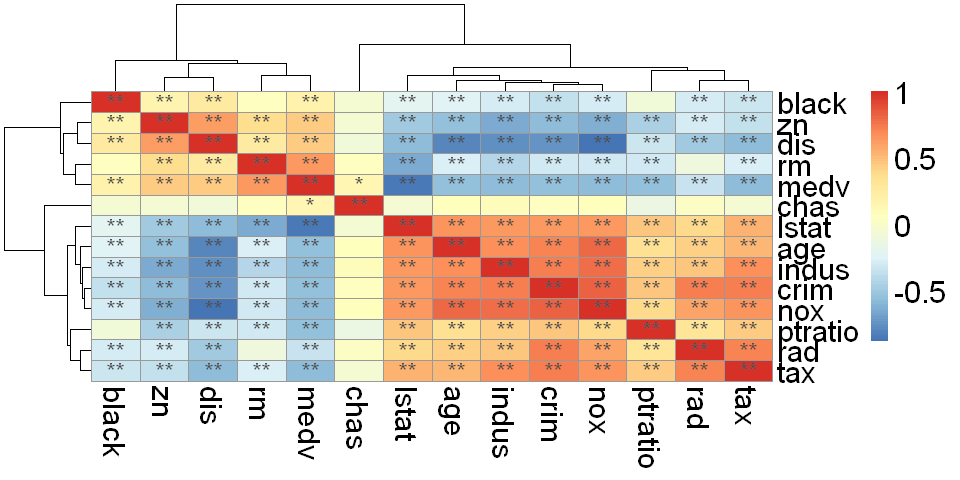

In [105]:
#?pheatmap
#?psych
pr<-corr.test(Boston,Boston,method="spearman")
pheatmap(pr$r,display_numbers = matrix(ifelse(pr$p <= 0.01, "**", ifelse(pr$p<= 0.05 ,"*"," ")), nrow(pr$p)),fontsize=18)
# nox has a strong relationship with crime rate

      crim         zn      indus       chas        nox         rm        age 
-0.3883046  0.3604453 -0.4837252  0.1752602 -0.4273208  0.6953599 -0.3769546 
       dis        rad        tax    ptratio      black      lstat       medv 
 0.2499287 -0.3816262 -0.4685359 -0.5077867  0.3334608 -0.7376627  1.0000000 


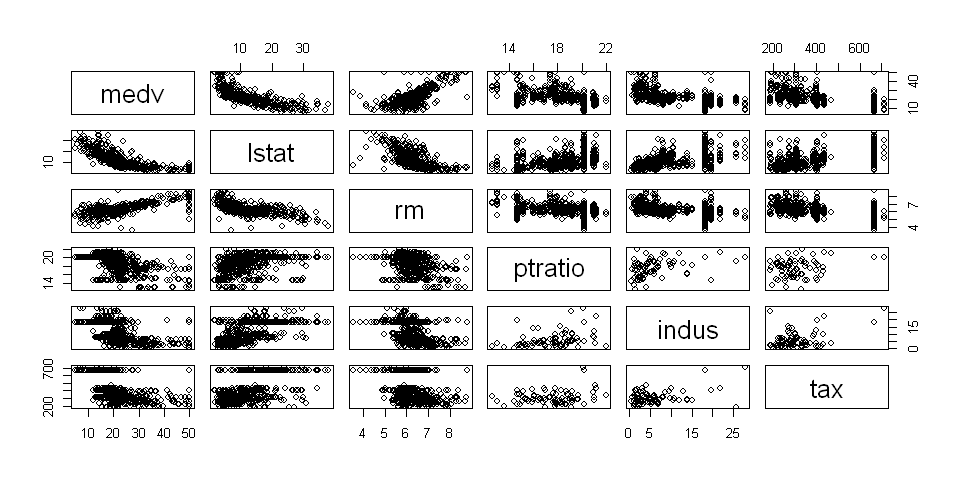

In [108]:
all_correlations = cor( Boston )
print( all_correlations[,14] )
cols = c(14,13,6,11,3,10)
pairs( Boston[,cols] )

In [112]:
table(Boston$chas)


  0   1 
471  35 

In [113]:
median(Boston$ptratio)

[1] 19.05

In [115]:
# there are two towns with lowest medv value of 5
(seltown <- Boston[Boston$medv == min(Boston$medv),])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
399,38.3518,0,18.1,0,0.693,5.453,100,1.4896,24,666,20.2,396.90,30.59,5
406,67.9208,0,18.1,0,0.693,5.683,100,1.4254,24,666,20.2,384.97,22.98,5


In [117]:
#  > 7 rooms
nrow(Boston[Boston$rm > 7,])
#  > 8 rooms
nrow(Boston[Boston$rm > 8,])  

[1] 64

[1] 13

Exercise10 (p.123, Chap.3)

In [91]:
require(ISLR)
data(Carseats)
md<- lm(Sales ~ Price + Urban + US, data=Carseats)
summary(md)


Call:
lm(formula = Sales ~ Price + Urban + US, data = Carseats)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.9206 -1.6220 -0.0564  1.5786  7.0581 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.043469   0.651012  20.036  < 2e-16 ***
Price       -0.054459   0.005242 -10.389  < 2e-16 ***
UrbanYes    -0.021916   0.271650  -0.081    0.936    
USYes        1.200573   0.259042   4.635 4.86e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.472 on 396 degrees of freedom
Multiple R-squared:  0.2393,	Adjusted R-squared:  0.2335 
F-statistic: 41.52 on 3 and 396 DF,  p-value: < 2.2e-16


In [119]:
confint(md,level=.9)

,5 %,95 %
(Intercept),6.27596881,7.7892183
TV,0.04309018,0.0519831


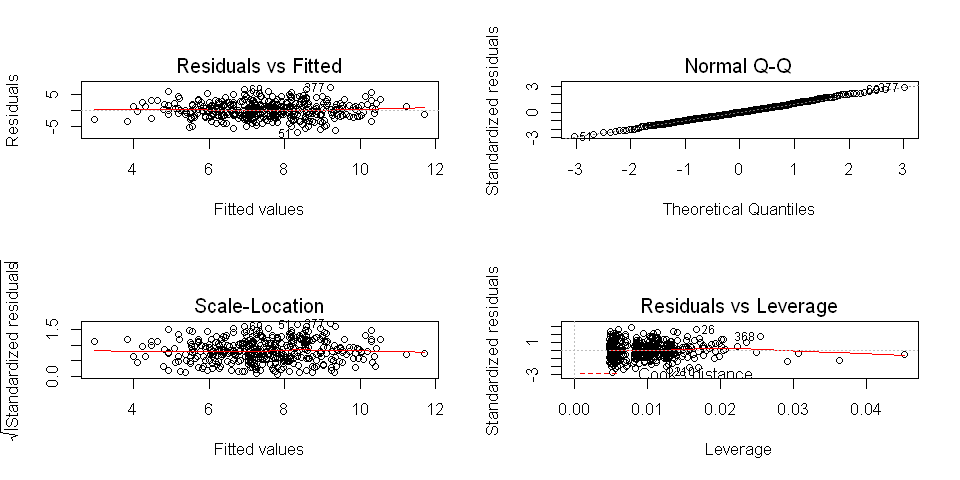

Loading required package: car
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'car'"

ERROR: Error in qqPlot(md, main = "QQ Plot"): could not find function "qqPlot"


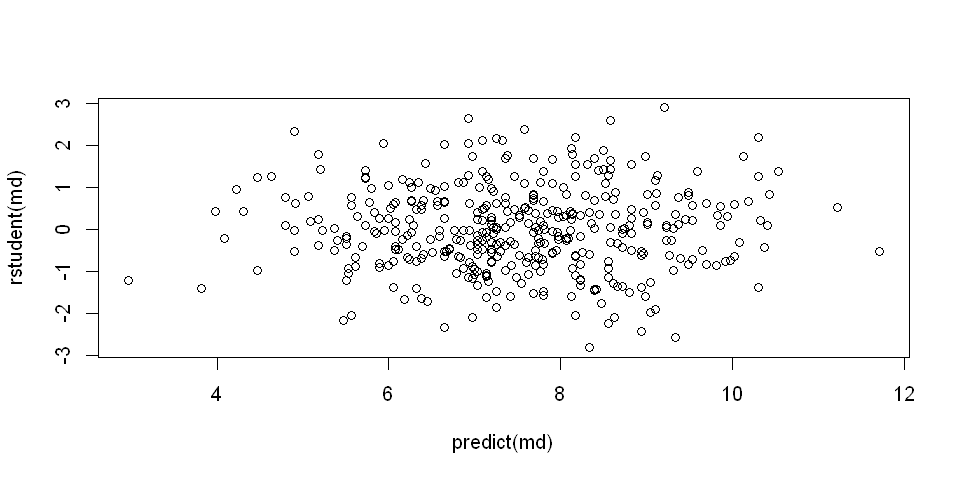

In [94]:
par(mfrow=c(2,2))
# residuals v fitted plot doesn't show strong outliers
plot(md)  
par(mfrow=c(1,1))
# studentized residuals within -3 to 3 range
plot(predict(md), rstudent(md))
# load car packages
require(car)
# no evidence of outliers
qqPlot(md, main="QQ Plot")  # studentized resid
leveragePlots(md)  # leverage plots
plot(hatvalues(md))
# average obs leverage (p+1)/n = (2+1)/400 = 0.0075

Exercise15(p.126, Chap.3）

In [82]:
if( ! require("ISLR") ){ install.packages("ISLR") }

library(MASS)

set.seed(1)

# Loop over each predictor and look for a statistically signficant simple linear regression: 
crim = Boston[,1]  
model_f_value = c()
model_p_value = c()
univariate_beta_value = c()
possible_predictors = colnames(Boston)
for( pi in 1:length(possible_predictors) ){
  if( possible_predictors[pi] == 'crim' ){ next }
  x = Boston[,pi] 
  m = lm( crim ~ x, data=Boston )
  s = summary(m)
  model_f_value = c(model_f_value, s$fstatistic[1] )
  model_p_value = c(model_p_value, anova(m)$'Pr(>F)'[1] )
  univariate_beta_value = c(univariate_beta_value, coefficients(m)['x'])
  print( sprintf("%s %10.6f", possible_predictors[pi], coefficients(m)['x']) )
}


[1] "zn  -0.073935"
[1] "indus   0.509776"
[1] "chas  -1.892777"
[1] "nox  31.248531"
[1] "rm  -2.684051"
[1] "age   0.107786"
[1] "dis  -1.550902"
[1] "rad   0.617911"
[1] "tax   0.029742"
[1] "ptratio   1.151983"
[1] "black  -0.036280"
[1] "lstat   0.548805"
[1] "medv  -0.363160"


In [83]:
# Lets look at each models F-statisics:
# 
DF = data.frame( feature=colnames(Boston)[-1], f_values=model_f_value, p_values=model_p_value )
DF[order(model_f_value),] 
#
# Consider a model to significant if the p-value < 0.01.  Every model is signficant except one 
# this is chas = Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

# Fit all of the predictors:
gm = lm( crim ~ ., data=Boston )
summary( gm )

multivariate_beta_values = coefficients(gm)
multivariate_beta_values = multivariate_beta_values[ possible_predictors[-1] ] # order the coefficients in the same order as the univariate coefficients 


,feature,f_values,p_values
3,chas,1.579364,2.094345e-01
1,zn,21.102782,5.506472e-06
5,rm,25.450204,6.346703e-07
10,ptratio,46.259453,2.942922e-11
6,age,71.619402,2.854869e-16
7,dis,84.887810,8.519949e-19
11,black,87.739763,2.487274e-19
13,medv,89.486115,1.173987e-19
2,indus,99.817037,1.450349e-21
4,nox,108.555329,3.751739e-23



Call:
lm(formula = crim ~ ., data = Boston)

Residuals:
   Min     1Q Median     3Q    Max 
-9.924 -2.120 -0.353  1.019 75.051 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  17.033228   7.234903   2.354 0.018949 *  
zn            0.044855   0.018734   2.394 0.017025 *  
indus        -0.063855   0.083407  -0.766 0.444294    
chas         -0.749134   1.180147  -0.635 0.525867    
nox         -10.313535   5.275536  -1.955 0.051152 .  
rm            0.430131   0.612830   0.702 0.483089    
age           0.001452   0.017925   0.081 0.935488    
dis          -0.987176   0.281817  -3.503 0.000502 ***
rad           0.588209   0.088049   6.680 6.46e-11 ***
tax          -0.003780   0.005156  -0.733 0.463793    
ptratio      -0.271081   0.186450  -1.454 0.146611    
black        -0.007538   0.003673  -2.052 0.040702 *  
lstat         0.126211   0.075725   1.667 0.096208 .  
medv         -0.198887   0.060516  -3.287 0.001087 ** 
---
Signif. codes:  0 '***' 0.0

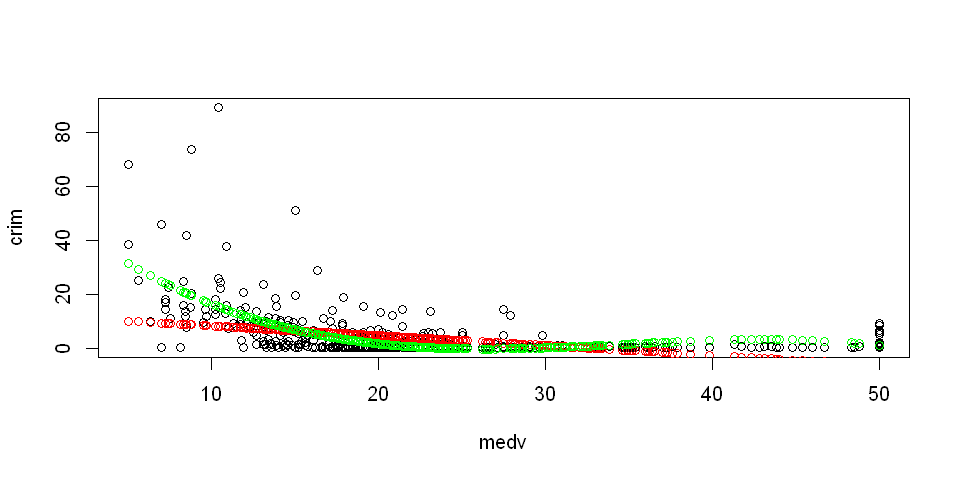

In [121]:
# Lets look at how the non-linear model compares to the linear model:
# 
m_1 = lm( crim ~ medv, data=Boston )
m_3 = lm( crim ~ poly(medv,3), data=Boston )

#postscript("../../WriteUp/Graphics/Chapter3/prob_15_crim_vs_medv.eps", onefile=FALSE, horizontal=FALSE)
plot( crim ~ medv, data=Boston )
lines( Boston$medv, predict( m_1 ), col='red', type='p' )
lines( Boston$medv, predict( m_3 ), col='green', type='p' )
#dev.off()

In [97]:
library(MASS)
Boston

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9
